# Preliminary operations

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Homework1

/gdrive/MyDrive/Homework1


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip install visualkeras
import visualkeras

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 7.4 MB/s 
2.9.2


# Common definitions

Definitions of Image Data Generators and augmentation

In [ ]:
aug_generator = ImageDataGenerator(rotation_range=180,
                                    zoom_range=0.2,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    brightness_range=[0.6,1.4],
                                    fill_mode='reflect',
                                    horizontal_flip=False,
                                    vertical_flip=False,
                                    #rescale=1/255.,
                                    preprocessing_function=None, #Included in the NN
                                   )

In [ ]:
def define_generators(directory, bs, aug_gen):

  generators = {}
  training_dir = os.path.join(directory, 'train') 
  validation_dir = os.path.join(directory, 'val') 
  test_dir = os.path.join(directory, 'test') 

  generators['train'] = aug_gen.flow_from_directory(directory=training_dir,
                                                        target_size=(96,96),
                                                        color_mode='rgb',
                                                        classes=None,
                                                        class_mode='categorical',
                                                        batch_size=bs,
                                                        shuffle=True,
                                                        seed=seed)


  # VALIDATION SET
  generators['val'] = ImageDataGenerator(#rescale=1/255.
                                         ).flow_from_directory(directory=validation_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=None,
                                                class_mode='categorical',
                                                batch_size=bs,
                                                shuffle=False,
                                                seed=seed)

  # TEST SET
  generators['test'] = ImageDataGenerator(#rescale=1/255.
                                          ).flow_from_directory(directory=test_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=None,
                                                class_mode='categorical',
                                                batch_size=bs,
                                                shuffle=False,
                                                seed=seed)

  return generators

In [ ]:
labels = {
    0:'Species1', 
    1:'Species2', 
    2:'Species3', 
    3:'Species4', 
    4:'Species5', 
    5:'Species6',
    6:'Species7', 
    7:'Species8'}

Definition of global parameters and of "evaluate_model", a hand-written function to evaluate the models' performances

In [ ]:
input_shape = (96, 96, 3)
output_dim = 8
epochs = 200
mtrcs = ['accuracy']
monmtr = 'val_accuracy'

In [ ]:
def evaluate_model(model_name, test_set, target):
  model = tfk.models.load_model(model_name)
  predictions = model.predict(test_set)
  metrics= {
    "model": model_name,
    "predictions" : predictions,
    "target": target,
    "cm": confusion_matrix(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), normalize='true', ),
    "accuracy" : accuracy_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1)),
    "precision" : precision_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "recall" : recall_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "f1" : f1_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro')  }
  
  print("Model: "+ str(metrics["model"]))
  print("Accuracy: "+ str(metrics["accuracy"]))
  print("F1 score: "+ str(metrics["f1"]))
  cm = metrics["cm"]
  plt.figure(figsize=(10,8))
  sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=list(labels.values()), yticklabels=list(labels.values()))
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  return metrics

In [ ]:
dataset_dir = "dataset_homework1"
bs = 64

In [ ]:
gens = define_generators(dataset_dir, bs, aug_generator)

train_gen = gens['train']
valid_gen = gens['val']
test_gen = gens['test']

train_target = train_gen.classes
val_target = valid_gen.classes
test_target = test_gen.classes

train_target_cat = tfk.utils.to_categorical(train_gen.classes)
val_target_cat = tfk.utils.to_categorical(valid_gen.classes)
test_target_cat = tfk.utils.to_categorical(test_gen.classes)

Found 2829 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.


# Training

We explored different paths in the training to assess the best configuration: one with an unbalanced training set using a weighted loss and one with a balanced training set

## 1. Unbalanced dataset with class weights

Best VGG_6++ --> Test Accuracy: 0.8259668508287292

In [ ]:
dataset_dir = "dataset_homework1"
bs = 64 

In [ ]:
gens = define_generators(dataset_dir, bs, aug_generator)

train_gen = gens['train']
valid_gen = gens['val']
test_gen = gens['test']

train_target = train_gen.classes
val_target = valid_gen.classes
test_target = test_gen.classes

train_target_cat = tfk.utils.to_categorical(train_gen.classes)
val_target_cat = tfk.utils.to_categorical(valid_gen.classes)
test_target_cat = tfk.utils.to_categorical(test_gen.classes)

Found 2829 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.


In [ ]:
from sklearn.utils import  compute_class_weight
class_weights =  compute_class_weight(class_weight = "balanced",
                              classes = np.unique(train_target),
                              y = train_target)
class_weights = dict(zip(np.unique(train_gen.classes), class_weights))
class_weights

{0: 2.389358108108108,
 1: 0.8320588235294117,
 2: 0.8583131067961165,
 3: 0.8667279411764706,
 4: 0.8340212264150944,
 5: 1.9978813559322033,
 6: 0.8243006993006993,
 7: 0.8709975369458128}

### Learning capabilities
No regularization ---> Test Accuracy: 0.8121546961325967

In [ ]:
# Download the VGG19 model
supernet = tfk.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg',
)

In [ ]:
def build_model_2(input_shape, drop_rate, l_rate):

""" Function to define the model, we imported the VGG19 and we added some layers to use Trasfer Learning"""

  supernet.trainable = False
  
  inputs = tfk.Input(shape=input_shape)
  x = tf.keras.applications.vgg19.preprocess_input(inputs)

  x = supernet(x)
  x = tfk.layers.Flatten()(x)
  x = tfkl.Dropout(drop_rate, seed=seed)(x)

  x = tfkl.Dense(
      256, 
      name='Classifier_layer',
      activation='relu',
      kernel_initializer = tfk.initializers.HeUniform(seed)
      )(x)

  x = tfkl.Dropout(drop_rate, seed=seed)(x)
  outputs = tfkl.Dense(
      output_dim, 
      name='Output_layer',
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed)
      )(x)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(l_rate), metrics=mtrcs)

  return model

In [ ]:
drop_rate = 0.1
l_rate = 1e-4

model = build_model_2(input_shape, drop_rate, l_rate)
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 tf.__operators__.getitem_5   (None, 96, 96, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dropout_10 (Dropout)        (None, 512)               0     

In [ ]:
# Set all layers to trainable, 
tn = 'vgg19'
for i, layer in enumerate(model.get_layer(tn).layers):
   print(i, layer.name, layer.trainable)

0 input_11 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 False
19 block5_conv3 False
20 block5_conv4 False
21 block5_pool False
22 global_average_pooling2d_5 False


In [ ]:
d = 17
model.get_layer(tn).trainable = True
for i, layer in enumerate(model.get_layer(tn).layers[:d]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer(tn).layers):
   print(i, layer.name, layer.trainable)

0 input_11 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
22 global_average_pooling2d_5 True


In [ ]:
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 input_12 True
1 tf.__operators__.getitem_5 True
2 tf.nn.bias_add_5 True
3 vgg19 True
4 flatten_5 True
5 dropout_10 True
6 Classifier_layer True
7 dropout_11 True
8 Output_layer True


In [ ]:
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=l_rate), metrics=mtrcs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 tf.__operators__.getitem_5   (None, 96, 96, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dropout_10 (Dropout)        (None, 512)               0     

In [ ]:
history = model.fit(
    x = train_gen,
    epochs = epochs,
    class_weight = class_weights,
    batch_size = bs, 
    validation_data = valid_gen,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor=monmtr, patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor=monmtr, patience=5, factor=0.5, min_lr=1e-8),
    ] 
).history

Epoch 1/200
45/45 [==============================] - 17s 352ms/step - loss: 2.0870 - accuracy: 0.2432 - val_loss: 1.5372 - val_accuracy: 0.4217 - lr: 1.0000e-04
Epoch 2/200
45/45 [==============================] - 13s 288ms/step - loss: 1.5798 - accuracy: 0.3839 - val_loss: 1.3337 - val_accuracy: 0.4929 - lr: 1.0000e-04
Epoch 3/200
45/45 [==============================] - 13s 287ms/step - loss: 1.4113 - accuracy: 0.4662 - val_loss: 1.2570 - val_accuracy: 0.5641 - lr: 1.0000e-04
Epoch 4/200
45/45 [==============================] - 13s 279ms/step - loss: 1.2895 - accuracy: 0.5239 - val_loss: 1.2408 - val_accuracy: 0.5556 - lr: 1.0000e-04
Epoch 5/200
45/45 [==============================] - 23s 520ms/step - loss: 1.1898 - accuracy: 0.5624 - val_loss: 1.1667 - val_accuracy: 0.6011 - lr: 1.0000e-04
Epoch 6/200
45/45 [==============================] - 21s 475ms/step - loss: 1.0671 - accuracy: 0.6115 - val_loss: 1.0558 - val_accuracy: 0.6353 - lr: 1.0000e-04
Epoch 7/200
45/45 [===============

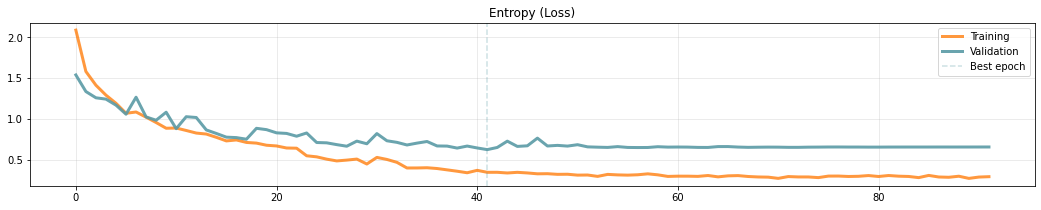

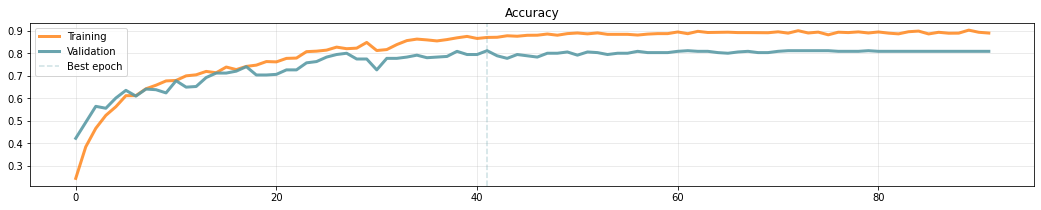

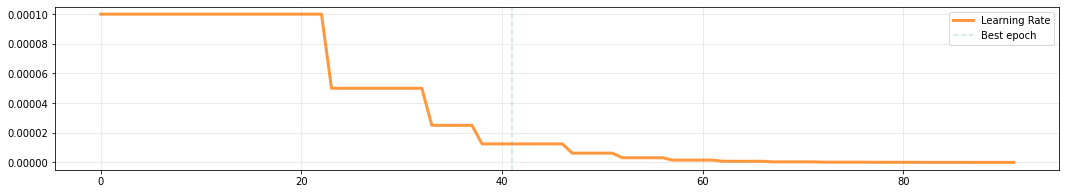

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(18,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Entropy (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()


plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save("models/VGG_0") #save the model

In [ ]:
mt = model.evaluate(train_gen, return_dict=True)
mv = model.evaluate(valid_gen, return_dict=True)

print("Accuracy: ")
print("     (Train) ", mt['accuracy'])
print("     (Valid) ", mv['accuracy'])

6/6 [==============================] - 1s 87ms/step - loss: 0.6213 - accuracy: 0.8120
Accuracy: 
     (Train)  0.891834557056427
     (Valid)  0.811965823173523


6/6 [==============================] - 1s 163ms/step
Model: models/VGG_0
Accuracy: 0.8121546961325967
F1 score: 0.7978729279423611


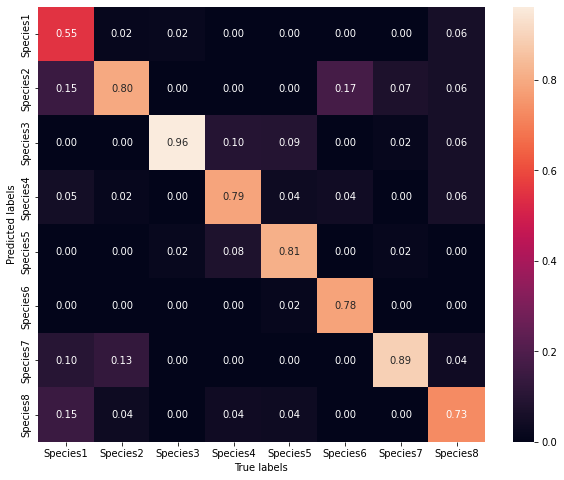

In [ ]:
ret = evaluate_model("models/VGG_0", test_gen, test_target_cat) 

### Regularization L2

Training A - low droput (dp_rate= 0.1), low regularization (lambda= 0.001)
--> Val Accuracy: 0.7900552486187845




In [ ]:
def build_model_tf(input_shape, drop_rate, lmbd, l_rate):

  supernet.trainable = False
  
  inputs = tfk.Input(shape=input_shape)
  x = tf.keras.applications.vgg19.preprocess_input(inputs)

  x = supernet(x)
  #x = tfk.layers.GlobalAveragePooling2D()(x)
  x = tfk.layers.Flatten()(x)
  x = tfkl.Dropout(drop_rate, seed=seed)(x)

  x = tfkl.Dense(
      256, 
      name='Classifier_layer',
      activation='relu',
      kernel_regularizer=tf.keras.regularizers.l2(lmbd),
      kernel_initializer = tfk.initializers.HeUniform(seed)
      )(x)

  x = tfkl.Dropout(drop_rate, seed=seed)(x)
  outputs = tfkl.Dense(
      output_dim, 
      name='Output_layer',
      activation='softmax',
      kernel_regularizer=tf.keras.regularizers.l2(lmbd),
      kernel_initializer = tfk.initializers.GlorotUniform(seed)
      )(x)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(l_rate), metrics=mtrcs)

  return model

In [ ]:
dropout_rate = 0.1
lr = 1e-3
l2 = 1e-3

In [ ]:
supernet = tfk.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg'
)

In [ ]:
# Build model 
model = build_model_tf(input_shape, dropout_rate, l2, lr) 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 tf.__operators__.getitem_4   (None, 96, 96, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dropout_8 (Dropout)         (None, 512)               0     

In [ ]:
# Set all layers to trainable
tn = 'vgg19'
for i, layer in enumerate(model.get_layer(tn).layers):
   print(i, layer.name, layer.trainable)

0 input_9 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 False
19 block5_conv3 False
20 block5_conv4 False
21 block5_pool False
22 global_average_pooling2d_4 False


In [ ]:
d = 17
model.get_layer(tn).trainable = True
for i, layer in enumerate(model.get_layer(tn).layers[:d]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer(tn).layers):
   print(i, layer.name, layer.trainable)

0 input_9 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
22 global_average_pooling2d_4 True


In [ ]:
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 input_10 True
1 tf.__operators__.getitem_4 True
2 tf.nn.bias_add_4 True
3 vgg19 True
4 flatten_4 True
5 dropout_8 True
6 Classifier_layer True
7 dropout_9 True
8 Output_layer True


In [ ]:
l_rate = 1e-4
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=l_rate), metrics=mtrcs)

In [ ]:
history = model.fit(
    x = train_gen,
    epochs = epochs,
    class_weight = class_weights,
    batch_size = bs, 
    validation_data = valid_gen,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor=monmtr, patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor=monmtr, patience=3, factor=0.5, min_lr=1e-7),
    ] 
).history

Epoch 1/200
45/45 [==============================] - 14s 285ms/step - loss: 2.6921 - accuracy: 0.2453 - val_loss: 1.9542 - val_accuracy: 0.4672 - lr: 1.0000e-04
Epoch 2/200
45/45 [==============================] - 13s 286ms/step - loss: 2.0559 - accuracy: 0.4150 - val_loss: 1.7498 - val_accuracy: 0.4986 - lr: 1.0000e-04
Epoch 3/200
45/45 [==============================] - 13s 297ms/step - loss: 1.8416 - accuracy: 0.5150 - val_loss: 1.7319 - val_accuracy: 0.5299 - lr: 1.0000e-04
Epoch 4/200
45/45 [==============================] - 13s 280ms/step - loss: 1.7229 - accuracy: 0.5454 - val_loss: 1.6295 - val_accuracy: 0.5840 - lr: 1.0000e-04
Epoch 5/200
45/45 [==============================] - 13s 278ms/step - loss: 1.6420 - accuracy: 0.5691 - val_loss: 1.8239 - val_accuracy: 0.5670 - lr: 1.0000e-04
Epoch 6/200
45/45 [==============================] - 13s 280ms/step - loss: 1.5121 - accuracy: 0.6228 - val_loss: 1.7980 - val_accuracy: 0.5584 - lr: 1.0000e-04
Epoch 7/200
45/45 [===============

In [ ]:
model.save("models/VGG_classweights_1")

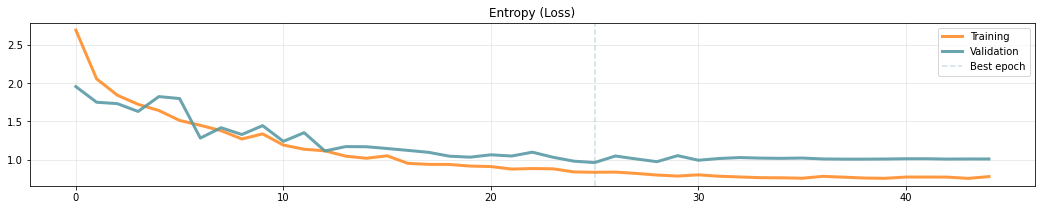

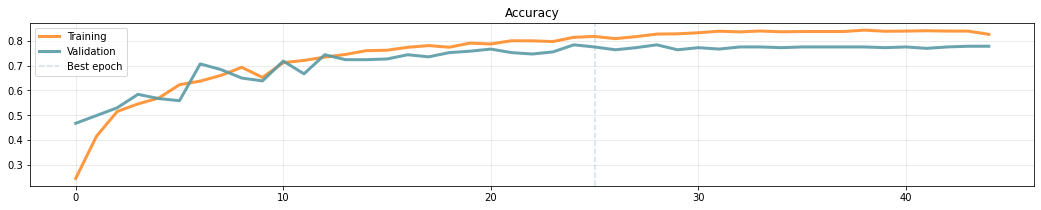

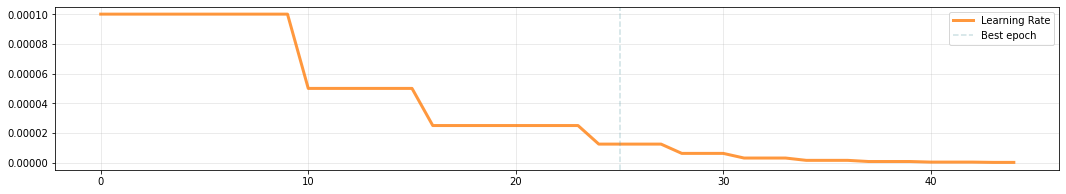

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(18,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Entropy (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()


plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

6/6 [==============================] - 59s 12s/step
Model: models/VGG_classweights_1
Accuracy: 0.7762430939226519
F1 score: 0.7411936384735068


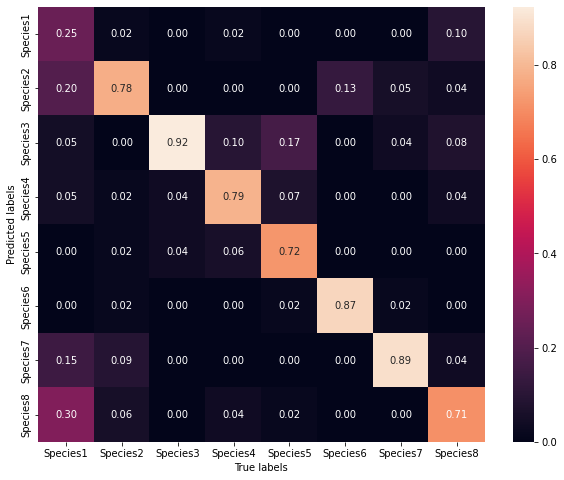

In [ ]:
res = evaluate_model("models/VGG_classweights_1", test_gen, test_target_cat)

### Regularization L1L2

In [ ]:
model_name = "VGG_6"
model_save_path = os.path.join("models_attempts", model_name) 

In [ ]:
training_set_TF = train_gen
validation_set_TF = valid_gen
test_set_TF = test_gen

Training A - low droput (dp_rate= 0.1), low regularization (lambda= 0.001)
--> Val Accuracy: 0.7900552486187845




In [ ]:
def build_model_2(input_shape, drop_rate, elastic_lambda, l_rate):

  supernet.trainable = False
  
  inputs = tfk.Input(shape=input_shape)
  x = tf.keras.applications.vgg19.preprocess_input(inputs)

  x = supernet(x)
  #x = tfk.layers.GlobalAveragePooling2D()(x)
  x = tfk.layers.Flatten()(x)
  x = tfkl.Dropout(drop_rate, seed=seed)(x)

  x = tfkl.Dense(
      256, 
      name='Classifier_layer',
      activation='relu',
      kernel_initializer = tfk.initializers.HeUniform(seed),
      kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda)
      )(x)

  x = tfkl.Dropout(drop_rate, seed=seed)(x)
  outputs = tfkl.Dense(
      output_dim, 
      name='Output_layer',
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed),
      kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda)
      )(x)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(l_rate), metrics=mtrcs)

  return model

In [ ]:
  # Download and plot the VGG16 model
supernet = tfk.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg',
    classifier_activation='softmax'
)

In [ ]:
drop_rate = 0.1
elastic_lambda = 1e-3
l_rate = 1e-4

model = build_model_2(input_shape, drop_rate, elastic_lambda, l_rate)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 tf.__operators__.getitem_13  (None, 96, 96, 3)        0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_13 (TFOpLamb  (None, 96, 96, 3)        0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_13 (Flatten)        (None, 512)               0         
                                                                 
 dropout_26 (Dropout)        (None, 512)               0     

In [ ]:
# Set all layers to trainable
tn = 'vgg19'
for i, layer in enumerate(model.get_layer(tn).layers):
   print(i, layer.name, layer.trainable)

0 input_25 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 False
19 block5_conv3 False
20 block5_conv4 False
21 block5_pool False
22 global_average_pooling2d_11 False


In [ ]:
d = 17
model.get_layer(tn).trainable = True
for i, layer in enumerate(model.get_layer(tn).layers[:d]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer(tn).layers):
   print(i, layer.name, layer.trainable)

0 input_25 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
22 global_average_pooling2d_11 True


In [ ]:
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 input_26 True
1 tf.__operators__.getitem_13 True
2 tf.nn.bias_add_13 True
3 vgg19 True
4 flatten_13 True
5 dropout_26 True
6 Classifier_layer True
7 dropout_27 True
8 Output_layer True


In [ ]:
l_rate = 1e-4
eps = 1e-07
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=l_rate, epsilon=eps), metrics=mtrcs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 tf.__operators__.getitem_13  (None, 96, 96, 3)        0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_13 (TFOpLamb  (None, 96, 96, 3)        0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_13 (Flatten)        (None, 512)               0         
                                                                 
 dropout_26 (Dropout)        (None, 512)               0     

In [ ]:
# Train the model
history = model.fit(
    x = training_set_TF,
    epochs = epochs,
    class_weight=class_weights,
    validation_data = validation_set_TF,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor=monmtr, patience=20, restore_best_weights=True),
).history

Epoch 1/100
354/354 [==============================] - 19s 51ms/step - loss: 8.3879 - accuracy: 0.3630 - val_loss: 6.9531 - val_accuracy: 0.5014
Epoch 2/100
354/354 [==============================] - 16s 46ms/step - loss: 5.9689 - accuracy: 0.4938 - val_loss: 5.0429 - val_accuracy: 0.5128
Epoch 3/100
354/354 [==============================] - 16s 46ms/step - loss: 4.3852 - accuracy: 0.5659 - val_loss: 3.8426 - val_accuracy: 0.6268
Epoch 4/100
354/354 [==============================] - 19s 53ms/step - loss: 3.4515 - accuracy: 0.6274 - val_loss: 3.2190 - val_accuracy: 0.6638
Epoch 5/100
354/354 [==============================] - 16s 46ms/step - loss: 2.9093 - accuracy: 0.6610 - val_loss: 3.2059 - val_accuracy: 0.5670
Epoch 6/100
354/354 [==============================] - 19s 54ms/step - loss: 2.5788 - accuracy: 0.6698 - val_loss: 2.5425 - val_accuracy: 0.6353
Epoch 7/100
354/354 [==============================] - 18s 52ms/step - loss: 2.2865 - accuracy: 0.6914 - val_loss: 2.3359 - val_ac

In [ ]:
# Save best epoch model
model.save(model_save_path)

6/6 [==============================] - 1s 106ms/step
Model: models/VGG_6
Accuracy: 0.7900552486187845
F1 score: 0.7529163689571072


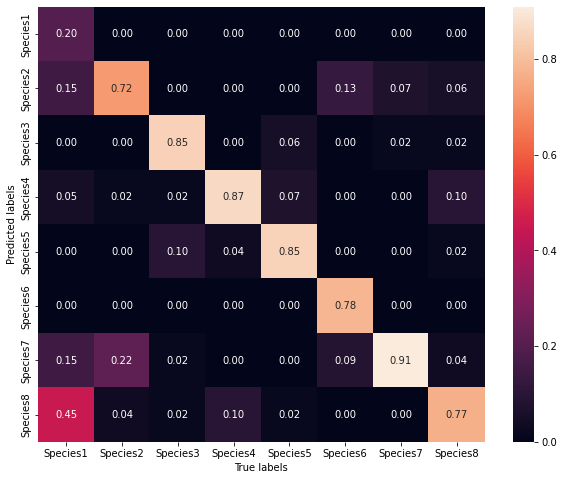

In [ ]:
ret = evaluate_model("models/VGG_6", test_gen, test_target_cat)

Training B - low droput (dp_rate= 0.1), higher regularization (lambda= 0.1)
--> Val Accuracy: 0.8259668508287292

In [ ]:
model_name = "VGG_6++"
model_save_path = os.path.join("models_attempts", model_name) 

In [ ]:
supernet = tfk.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg',
    classifier_activation='softmax'
)

In [ ]:
def build_model_2(input_shape, drop_rate, elastic_lambda, l_rate):

  supernet.trainable = False
  
  inputs = tfk.Input(shape=input_shape)
  x = tf.keras.applications.vgg19.preprocess_input(inputs)

  x = supernet(x)
  #x = tfk.layers.GlobalAveragePooling2D()(x)
  x = tfk.layers.Flatten()(x)
  x = tfkl.Dropout(drop_rate, seed=seed)(x)

  x = tfkl.Dense(
      256, 
      name='Classifier_layer',
      activation='relu',
      kernel_initializer = tfk.initializers.HeUniform(seed),
      kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda)
      )(x)

  x = tfkl.Dropout(drop_rate, seed=seed)(x)
  outputs = tfkl.Dense(
      output_dim, 
      name='Output_layer',
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed),
      kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda)
      )(x)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(l_rate), metrics=mtrcs)

  return model

In [ ]:
# Build model (for NO augmentation training)
drop_rate = 0.1
elastic_lambda = 1e-1
l_rate = 1e-4

model = build_model_2(input_shape, drop_rate, elastic_lambda, l_rate)
model.summary()

In [ ]:
# Set all layers to trainable
tn = 'vgg19'
for i, layer in enumerate(model.get_layer(tn).layers):
   print(i, layer.name, layer.trainable)

In [ ]:
d = 17
model.get_layer(tn).trainable = True
for i, layer in enumerate(model.get_layer(tn).layers[:d]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer(tn).layers):
   print(i, layer.name, layer.trainable)

In [ ]:
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

In [ ]:
l_rate = 1e-4
eps = 1e-07
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=l_rate, epsilon=eps), metrics=mtrcs)

In [ ]:
model.summary()

In [ ]:
# Train the model
history = model.fit(
    x = training_set_TF,
    epochs = epochs,
    batch_size = bs,
    class_weight=class_weights,
    validation_data = validation_set_TF,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor=monmtr, patience=20, restore_best_weights=True),
).history

Epoch 1/100
45/45 [==============================] - 618s 14s/step - loss: 748.5609 - accuracy: 0.2450 - val_loss: 715.6754 - val_accuracy: 0.4074
Epoch 2/100
45/45 [==============================] - 13s 280ms/step - loss: 685.9046 - accuracy: 0.3828 - val_loss: 654.3782 - val_accuracy: 0.4701
Epoch 3/100
45/45 [==============================] - 13s 279ms/step - loss: 625.3912 - accuracy: 0.4454 - val_loss: 596.0471 - val_accuracy: 0.5328
Epoch 4/100
45/45 [==============================] - 13s 277ms/step - loss: 568.5988 - accuracy: 0.5168 - val_loss: 541.1238 - val_accuracy: 0.5527
Epoch 5/100
45/45 [==============================] - 13s 286ms/step - loss: 514.7539 - accuracy: 0.5970 - val_loss: 488.8234 - val_accuracy: 0.5783
Epoch 6/100
45/45 [==============================] - 13s 279ms/step - loss: 464.6099 - accuracy: 0.6257 - val_loss: 439.6990 - val_accuracy: 0.6011
Epoch 7/100
45/45 [==============================] - 13s 279ms/step - loss: 416.4145 - accuracy: 0.6370 - val_los

In [ ]:
# Save best epoch model
model.save("models/VGG_6++")

6/6 [==============================] - 91s 16s/step
Model: models/VGG_6++
Accuracy: 0.8259668508287292
F1 score: 0.8135096407188249


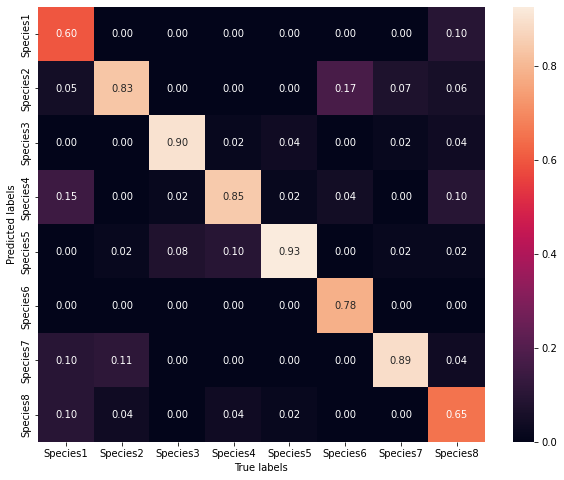

In [ ]:
ret = evaluate_model("models/VGG_6++", test_gen, test_target_cat)

Training C - higher droput (dp_rate= 0.3), higher regularization (lambda= 0.1)
--> Val Accuracy: 0.8149171270718232

In [ ]:
model_name = "VGG_6+++"
model_save_path = os.path.join("models_attempts", model_name) 

In [ ]:
input_shape = (96, 96, 3)
bs = 128
output_dim = 8
epochs = 200
mtrcs = ['accuracy']
monmtr = 'val_accuracy'

In [ ]:
supernet = tfk.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg',
    classifier_activation='softmax'
)

In [ ]:
def build_model_2(input_shape, drop_rate, elastic_lambda, l_rate):

  supernet.trainable = False
  
  inputs = tfk.Input(shape=input_shape)
  x = tf.keras.applications.vgg19.preprocess_input(inputs)

  x = supernet(x)
  #x = tfk.layers.GlobalAveragePooling2D()(x)
  x = tfk.layers.Flatten()(x)
  x = tfkl.Dropout(drop_rate, seed=seed)(x)

  x = tfkl.Dense(
      256, 
      name='Classifier_layer',
      activation='relu',
      kernel_initializer = tfk.initializers.HeUniform(seed),
      kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda)
      )(x)

  x = tfkl.Dropout(drop_rate, seed=seed)(x)
  outputs = tfkl.Dense(
      output_dim, 
      name='Output_layer',
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed),
      kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda)
      )(x)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(l_rate), metrics=mtrcs)

  return model

In [ ]:
# Build model (for NO augmentation training)
drop_rate = 0.3
elastic_lambda = 0.1
l_rate = 1e-4

model = build_model_2(input_shape, drop_rate, elastic_lambda, l_rate)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 tf.__operators__.getitem_4   (None, 96, 96, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dropout_8 (Dropout)         (None, 512)               0     

In [ ]:
# Set all layers to trainable
tn = 'vgg19'
for i, layer in enumerate(model.get_layer(tn).layers):
   print(i, layer.name, layer.trainable)

0 input_10 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 False
19 block5_conv3 False
20 block5_conv4 False
21 block5_pool False
22 global_average_pooling2d_5 False


In [ ]:
d = 17
model.get_layer(tn).trainable = True
for i, layer in enumerate(model.get_layer(tn).layers[:d]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer(tn).layers):
   print(i, layer.name, layer.trainable)

0 input_10 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
22 global_average_pooling2d_5 True


In [ ]:
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 input_11 True
1 tf.__operators__.getitem_4 True
2 tf.nn.bias_add_4 True
3 vgg19 True
4 flatten_4 True
5 dropout_8 True
6 Classifier_layer True
7 dropout_9 True
8 Output_layer True


In [ ]:
l_rate = 1e-4
eps = 1e-07
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=l_rate, epsilon=eps), metrics=mtrcs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 tf.__operators__.getitem_4   (None, 96, 96, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dropout_8 (Dropout)         (None, 512)               0     

In [ ]:
# Train the model
history = model.fit(
    x = training_set_TF,
    epochs = epochs,
    batch_size = bs,
    class_weight=class_weights,
    validation_data = validation_set_TF,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor=monmtr, patience=20, restore_best_weights=True),
).history

Epoch 1/200
45/45 [==============================] - 14s 285ms/step - loss: 750.1393 - accuracy: 0.1414 - val_loss: 716.4698 - val_accuracy: 0.2678
Epoch 2/200
45/45 [==============================] - 13s 277ms/step - loss: 686.4476 - accuracy: 0.2390 - val_loss: 655.0395 - val_accuracy: 0.2279
Epoch 3/200
45/45 [==============================] - 13s 276ms/step - loss: 626.5789 - accuracy: 0.2863 - val_loss: 596.5598 - val_accuracy: 0.3419
Epoch 4/200
45/45 [==============================] - 12s 276ms/step - loss: 569.4601 - accuracy: 0.3043 - val_loss: 541.2512 - val_accuracy: 0.3647
Epoch 5/200
45/45 [==============================] - 12s 275ms/step - loss: 515.7908 - accuracy: 0.3199 - val_loss: 488.7726 - val_accuracy: 0.4786
Epoch 6/200
45/45 [==============================] - 12s 274ms/step - loss: 464.4290 - accuracy: 0.3811 - val_loss: 439.4102 - val_accuracy: 0.5242
Epoch 7/200
45/45 [==============================] - 13s 276ms/step - loss: 416.8241 - accuracy: 0.4415 - val_lo

In [ ]:
model_save_path

'models_attempts/VGG_6+++'

In [ ]:
# Save best epoch model
model.save(model_save_path)

6/6 [==============================] - 125s 23s/step
Model: models/VGG_6+++
Accuracy: 0.8149171270718232
F1 score: 0.793129852375795


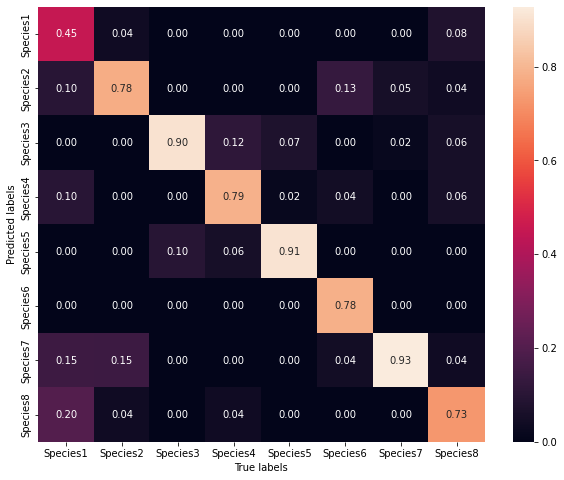

In [ ]:
ret = evaluate_model("models/VGG_6+++", test_gen, test_target_cat)

## 2. Balanced dataset (1000 each class)

Best VGG_balanced --> Test Accuracy: 0.8204419889502762

In [ ]:
dataset_dir = "balanced_dataset_1000"
bs = 64

In [ ]:
gens = define_generators(dataset_dir, bs, aug_generator)

train_gen = gens['train']
valid_gen = gens['val']
test_gen = gens['test']

train_target = train_gen.classes
val_target = valid_gen.classes
test_target = test_gen.classes

train_target_cat = tfk.utils.to_categorical(train_gen.classes)
val_target_cat = tfk.utils.to_categorical(valid_gen.classes)
test_target_cat = tfk.utils.to_categorical(test_gen.classes)

Found 8000 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.


In [ ]:
supernet = tfk.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg', # GAP
    classifier_activation='softmax'
)

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
def build_model_2(input_shape, drop_rate, elastic_lambda, l_rate):

  supernet.trainable = False
  
  inputs = tfk.Input(shape=input_shape)
  x = tf.keras.applications.vgg19.preprocess_input(inputs)

  x = supernet(x)
  #x = tfk.layers.Flatten()(x)
  x = tfkl.Dropout(drop_rate, seed=seed)(x)

  x = tfkl.Dense(
      256, 
      name='Classifier_layer',
      activation='relu',
      kernel_initializer = tfk.initializers.HeUniform(seed),
      kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda)
      )(x)

  x = tfkl.Dropout(drop_rate, seed=seed)(x)
  outputs = tfkl.Dense(
      output_dim, 
      name='Output_layer',
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed),
      kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda)
      )(x)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(l_rate), metrics=mtrcs)

  return model

In [ ]:
# Build model (for NO augmentation training)
drop_rate = 0.1
elastic_lambda = 1e-1
l_rate = 1e-4

model = build_model_2(input_shape, drop_rate, elastic_lambda, l_rate)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 96, 96, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)        0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [ ]:
# Set all layers to trainable
tn = 'vgg19'
for i, layer in enumerate(model.get_layer(tn).layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 False
19 block5_conv3 False
20 block5_conv4 False
21 block5_pool False
22 global_average_pooling2d False


In [ ]:
d = 17
model.get_layer(tn).trainable = True
for i, layer in enumerate(model.get_layer(tn).layers[:d]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer(tn).layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
22 global_average_pooling2d True


In [ ]:
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 input_2 True
1 tf.__operators__.getitem True
2 tf.nn.bias_add True
3 vgg19 True
4 flatten True
5 dropout True
6 Classifier_layer True
7 dropout_1 True
8 Output_layer True


In [ ]:
l_rate = 1e-4
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=l_rate), metrics=mtrcs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 96, 96, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)        0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [ ]:
# Train the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    batch_size = bs,
    validation_data = valid_gen,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor=monmtr, patience=20, restore_best_weights=True),
).history

Epoch 1/200
125/125 [==============================] - 1664s 13s/step - loss: 692.1868 - accuracy: 0.3428 - val_loss: 607.5140 - val_accuracy: 0.5556
Epoch 2/200
125/125 [==============================] - 35s 280ms/step - loss: 532.4410 - accuracy: 0.5245 - val_loss: 459.8460 - val_accuracy: 0.6182
Epoch 3/200
125/125 [==============================] - 35s 280ms/step - loss: 396.0592 - accuracy: 0.5890 - val_loss: 334.7975 - val_accuracy: 0.6667
Epoch 4/200
125/125 [==============================] - 35s 277ms/step - loss: 281.7525 - accuracy: 0.6515 - val_loss: 231.3342 - val_accuracy: 0.6439
Epoch 5/200
125/125 [==============================] - 35s 282ms/step - loss: 188.3722 - accuracy: 0.6794 - val_loss: 148.2051 - val_accuracy: 0.6980
Epoch 6/200
125/125 [==============================] - 35s 278ms/step - loss: 115.1596 - accuracy: 0.7078 - val_loss: 84.7704 - val_accuracy: 0.7521
Epoch 7/200
125/125 [==============================] - 36s 284ms/step - loss: 61.2315 - accuracy: 0.7

In [ ]:
# Save best epoch model
model.save("models/VGG_balanced")

6/6 [==============================] - 1s 154ms/step
Model: models/VGG_balanced
Accuracy: 0.8204419889502762
F1 score: 0.8086894231873745


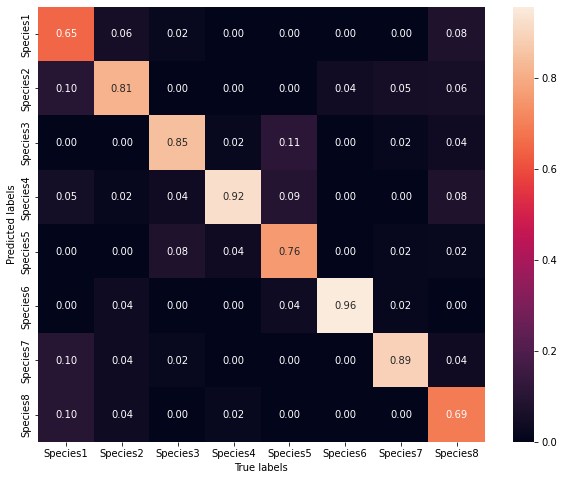

In [ ]:
ret = evaluate_model("models/VGG_balanced", test_gen, test_target_cat)

In [ ]:
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-5), metrics=mtrcs)
history = model.fit(
    x = train_gen,
    epochs = epochs,
    batch_size = bs,
    validation_data = valid_gen,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor=monmtr, patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor=monmtr, patience=3, factor=0.5, min_lr=1e-10),
    ] 
).history

Epoch 1/200
125/125 [==============================] - 39s 307ms/step - loss: 0.7035 - accuracy: 0.8355 - val_loss: 0.7861 - val_accuracy: 0.8120 - lr: 1.0000e-05
Epoch 2/200
125/125 [==============================] - 35s 279ms/step - loss: 0.6834 - accuracy: 0.8397 - val_loss: 0.7977 - val_accuracy: 0.8262 - lr: 1.0000e-05
Epoch 3/200
125/125 [==============================] - 35s 282ms/step - loss: 0.6665 - accuracy: 0.8465 - val_loss: 0.7770 - val_accuracy: 0.8262 - lr: 1.0000e-05
Epoch 4/200
125/125 [==============================] - 38s 301ms/step - loss: 0.6566 - accuracy: 0.8489 - val_loss: 0.7864 - val_accuracy: 0.8091 - lr: 1.0000e-05
Epoch 5/200
125/125 [==============================] - 35s 281ms/step - loss: 0.6594 - accuracy: 0.8446 - val_loss: 0.7798 - val_accuracy: 0.8120 - lr: 1.0000e-05
Epoch 6/200
125/125 [==============================] - 35s 283ms/step - loss: 0.6363 - accuracy: 0.8495 - val_loss: 0.7644 - val_accuracy: 0.8205 - lr: 5.0000e-06
Epoch 7/200
125/125 [=

In [ ]:
model.save("models/VGG_balanced+")

6/6 [==============================] - 1s 95ms/step
Model: models/VGG_balanced+
Accuracy: 0.7900552486187845
F1 score: 0.7745777845044148


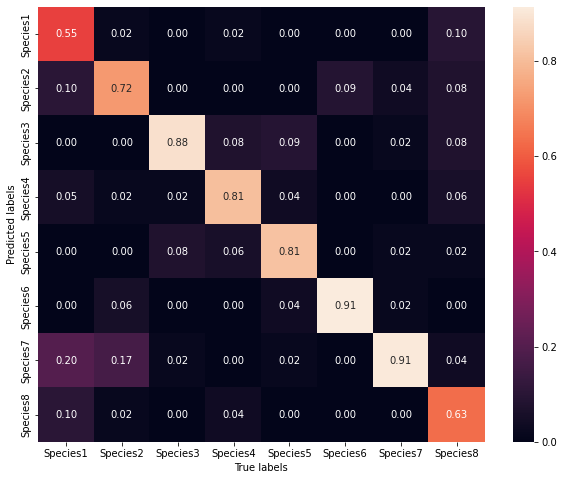

In [ ]:
ret = evaluate_model("models/VGG_balanced+", test_gen, test_target_cat)

### Revised weights

6/6 [==============================] - 1s 99ms/step
Model: models/VGG_balanced
Accuracy: 0.8204419889502762
F1 score: 0.8086894231873745


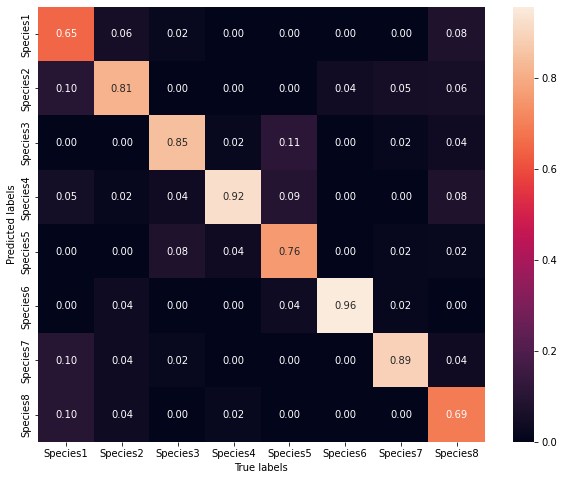

In [ ]:
bm = "models/VGG_balanced"
ret = evaluate_model(bm, test_gen, test_target_cat)

In [ ]:
cw1 = {}
r = 1./np.diag(ret['cm'])
for i in range(8):
  cw1[i]=r[i]

cw1

{0: 1.5384615384615383,
 1: 1.2272727272727273,
 2: 1.1818181818181819,
 3: 1.0833333333333333,
 4: 1.3170731707317072,
 5: 1.0454545454545454,
 6: 1.1224489795918369,
 7: 1.4444444444444444}

In [ ]:
cw2 = {}
r = 1-np.diag(ret['cm'])
for i in range(8):
  cw2[i]=r[i]

cw2

{0: 0.35,
 1: 0.18518518518518523,
 2: 0.15384615384615385,
 3: 0.07692307692307687,
 4: 0.2407407407407407,
 5: 0.04347826086956519,
 6: 0.10909090909090913,
 7: 0.3076923076923077}

In [ ]:
m = tfk.models.load_model(bm)
m.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-5), metrics=mtrcs)

In [ ]:
# Train the model
history = m.fit(
    x = train_gen,
    epochs = epochs,
    batch_size = bs,
    class_weight=cw1,
    validation_data = valid_gen,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor=monmtr, patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor=monmtr, patience=3, factor=0.5, min_lr=1e-8),
    ] 
).history

Epoch 1/200
125/125 [==============================] - 37s 286ms/step - loss: 0.8269 - accuracy: 0.8366 - val_loss: 0.7797 - val_accuracy: 0.8091 - lr: 1.0000e-05
Epoch 2/200
125/125 [==============================] - 34s 275ms/step - loss: 0.8195 - accuracy: 0.8363 - val_loss: 0.7760 - val_accuracy: 0.8120 - lr: 1.0000e-05
Epoch 3/200
125/125 [==============================] - 35s 283ms/step - loss: 0.8092 - accuracy: 0.8439 - val_loss: 0.7950 - val_accuracy: 0.8063 - lr: 1.0000e-05
Epoch 4/200
125/125 [==============================] - 35s 276ms/step - loss: 0.8120 - accuracy: 0.8403 - val_loss: 0.7787 - val_accuracy: 0.8120 - lr: 1.0000e-05
Epoch 5/200
125/125 [==============================] - 35s 283ms/step - loss: 0.7842 - accuracy: 0.8481 - val_loss: 0.7610 - val_accuracy: 0.8262 - lr: 1.0000e-05
Epoch 6/200
125/125 [==============================] - 36s 289ms/step - loss: 0.7891 - accuracy: 0.8447 - val_loss: 0.7727 - val_accuracy: 0.8148 - lr: 1.0000e-05
Epoch 7/200
125/125 [=

In [ ]:
m.save("models/VGG_balanced_revisedweights1")

6/6 [==============================] - 1s 99ms/step
Model: models/VGG_balanced_revisedweights1
Accuracy: 0.8121546961325967
F1 score: 0.7926713557787324


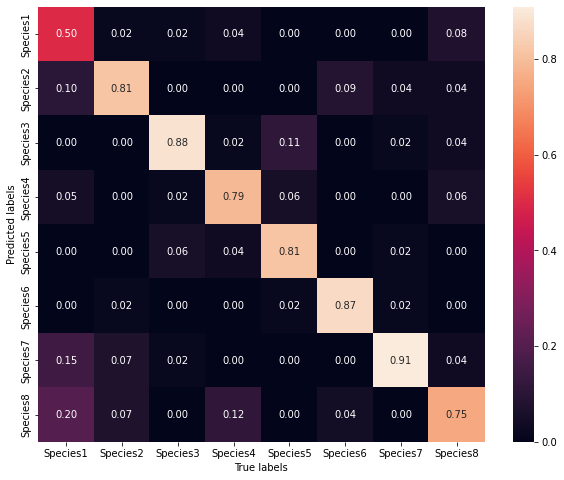

In [ ]:
ret = evaluate_model("models/VGG_balanced_revisedweights1", test_gen, test_target_cat)

In [ ]:
m = tfk.models.load_model(bm)
m.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-5), metrics=mtrcs)

In [ ]:
# Train the model
history = m.fit(
    x = train_gen,
    epochs = epochs,
    batch_size = bs,
    class_weight=cw2,
    validation_data = valid_gen,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor=monmtr, patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor=monmtr, patience=5, factor=0.5, min_lr=1e-11),
    ] 
).history

Epoch 1/200
125/125 [==============================] - 36s 279ms/step - loss: 0.3050 - accuracy: 0.8177 - val_loss: 0.7800 - val_accuracy: 0.8034 - lr: 1.0000e-05
Epoch 2/200
125/125 [==============================] - 34s 272ms/step - loss: 0.2855 - accuracy: 0.8080 - val_loss: 0.7650 - val_accuracy: 0.8034 - lr: 1.0000e-05
Epoch 3/200
125/125 [==============================] - 34s 271ms/step - loss: 0.2745 - accuracy: 0.8133 - val_loss: 0.7475 - val_accuracy: 0.7920 - lr: 1.0000e-05
Epoch 4/200
125/125 [==============================] - 35s 279ms/step - loss: 0.2663 - accuracy: 0.8086 - val_loss: 0.7426 - val_accuracy: 0.8063 - lr: 1.0000e-05
Epoch 5/200
125/125 [==============================] - 35s 278ms/step - loss: 0.2583 - accuracy: 0.8111 - val_loss: 0.7328 - val_accuracy: 0.8006 - lr: 1.0000e-05
Epoch 6/200
125/125 [==============================] - 34s 273ms/step - loss: 0.2527 - accuracy: 0.8106 - val_loss: 0.7318 - val_accuracy: 0.8177 - lr: 1.0000e-05
Epoch 7/200
125/125 [=

In [ ]:
m.save("models/VGG_balanced_revisedweights2")

6/6 [==============================] - 1s 111ms/step
Model: models/VGG_balanced_revisedweights2
Accuracy: 0.8011049723756906
F1 score: 0.7866298535363271


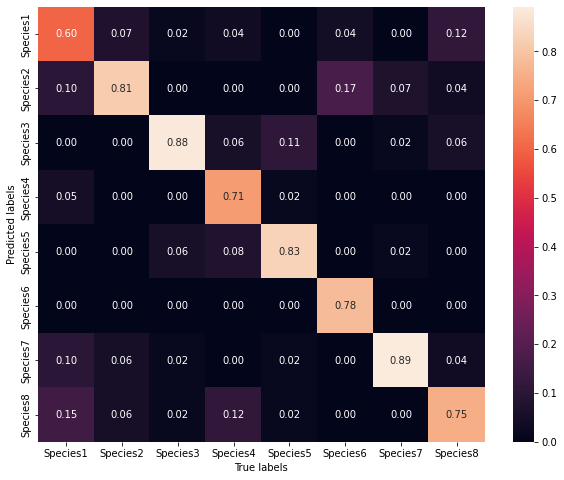

In [ ]:
ret = evaluate_model("models/VGG_balanced_revisedweights2", test_gen, test_target_cat)

# Training outcome
Better results with weighted loss than with the balanced data by means of augmentation. Best regularization technique is L1L2. 

---> best weights: VGG_6++